# Explore here

In [75]:
# Import
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Vectorize data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

# Splitting data
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Utils
import warnings

warnings.filterwarnings("ignore")

In [76]:
# Get data
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")

# Initial Data Display
df.head(10)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
5,https://www.brookings.edu/interactives/reopeni...,False
6,https://www.reuters.com/investigates/special-r...,False
7,https://www.theatlantic.com/magazine/archive/2...,False
8,https://www.vox.com/2020/6/17/21294680/john-bo...,False
9,https://www.theguardian.com/travel/2020/jun/18...,False


In [77]:
# DataFrame Dimensions
df.shape

(2999, 2)

In [78]:
# Basic Information on Data Types and Non-Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [79]:
# Search and Removal of Duplicate Data
duplicates = df.duplicated().sum()
print(duplicates)

# If Necessary
df = df.drop_duplicates()

630


In [80]:
# DataFrame Dimensions
df.shape

(2369, 2)

is_spam
False    2125
True      244
Name: count, dtype: int64


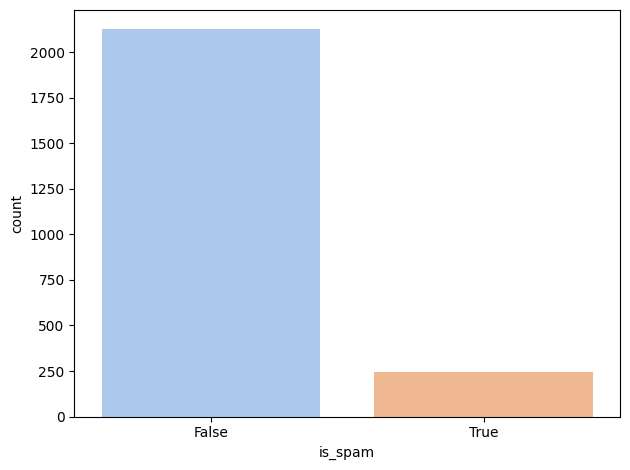

In [81]:
# Balancing analysis in variable to be predicted
print(df["is_spam"].value_counts())

sns.countplot(data = df, x = "is_spam", palette='pastel', hue= "is_spam", legend=False)
# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

Later, the dataset is balanced since the class to be predicted is a minority in the data (9:1 ratio).

In [82]:
# Text preprocessing
def clean_url(texto):
    cleaned = texto.lower()
    # Remove http and https
    cleaned = re.sub(r'https?://', ' ', cleaned)
    # Replace uninformative symbols with spaces
    cleaned = re.sub(r'[#?=&%_+:;]', ' ', cleaned)
    # Replace periods, slashes, and dashes with spaces
    cleaned = re.sub(r'[./-]', ' ', cleaned)
    # Replace domain values ​​with space
    cleaned = re.sub(r'\b(?:www|com|org|net|io|gov|edu|xyz|es)\b', ' ', cleaned)
    # Delete isolated numbers (but not those within words)
    cleaned = re.sub(r'\b\d+\b', ' ', cleaned)
    # Delete single-letter words
    cleaned = re.sub(r'\b[a-zA-Z]\b', ' ', cleaned)

    return cleaned.split()

In [83]:
df["url"] = df["url"].apply(clean_url)
df.head(10)

,url,is_spam
0,"[briefingday, us8, list, manage, unsubscribe]",True
1,[hvper],True
2,"[briefingday, v4n3i4f3]",True
3,"[briefingday, commentform]",False
4,"[briefingday, fan]",True
5,"[brookings, interactives, reopening, america, ...",False
6,"[reuters, investigates, special, report, healt...",False
7,"[theatlantic, magazine, archive, supermarkets,...",False
8,"[vox, john, bolton, book, excerpts, trump, ukr...",False
9,"[theguardian, travel, jun, end, of, tourism, c...",False


In [84]:
# Instantiate lemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Keeps those longer than 3
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
df["url"] = df["url"].apply(lemmatize_text)
df.head(10)

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",True
1,[hvper],True
2,"[briefingday, v4n3i4f3]",True
3,"[briefingday, commentform]",False
4,[briefingday],True
5,"[brookings, interactives, reopening, america, ...",False
6,"[reuters, investigates, special, report, healt...",False
7,"[theatlantic, magazine, archive, supermarket, ...",False
8,"[john, bolton, book, excerpt, trump, ukraine, ...",False
9,"[theguardian, travel, tourism, coronavirus, pa...",False


In [86]:
# Separate by classes
df_pos = df[df['is_spam'] == True]
df_neg = df[df['is_spam'] == False]

# Balance by resampling the minority
max_size = max(len(df_pos), len(df_neg))
df_pos_bal = resample(df_pos, replace=True, n_samples=max_size, random_state=42)
df_neg_bal = resample(df_neg, replace=True, n_samples=max_size, random_state=42)

# Combine and mix
df_balanced = pd.concat([df_pos_bal, df_neg_bal]).sample(frac=1, random_state=42)

In [87]:
tokens_list = df_balanced["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.9,               # Ignore tokens that appear in +90% of cases (not very informative)
    token_pattern=r"(?u)\b\w\w+\b",  # Words of at least 2 letters (avoid tokens like 'a', 'b', etc.)
    sublinear_tf=True,        # TF scale in logarithmic form (helps with short texts)
    norm='l2',                # Typical normalization
    lowercase=False
)

X = vectorizer.fit_transform(tokens_list).toarray()
y = df_balanced["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 16355))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [89]:
model = SVC(
    kernel="linear",
    C=1.0,
    random_state=42
)

model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [90]:
y_pred = model.predict(X_test)

In [91]:
accuracy_score(y_test, y_pred)

0.9941176470588236

In [92]:
accuracy_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy_test)
print("F1 score: ", f1_score_test)
print("Precision: ", precision_test)
print("Recall: ", recall_test)

Accuracy:  0.9941176470588236
F1 score:  0.9940405244338498
Precision:  0.9952267303102625
Recall:  0.9928571428571429


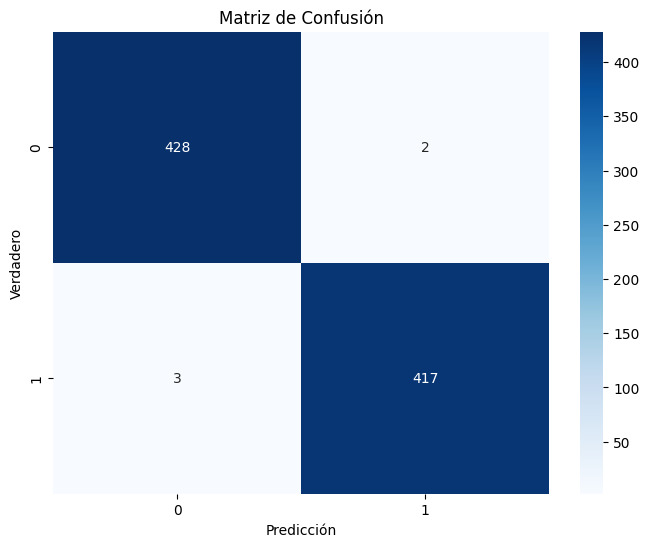

In [93]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Graph the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [94]:
def predict_spam(new_url):
    # Aplicar preprocesamiento y lematización
    processed_message = clean_url(new_url)
    lemmatized_message = lemmatize_text(processed_message, lemmatizer)

    # Unir tokens en una sola cadena
    lemmatized_message = " ".join(lemmatized_message)

    # Vectorizar utilizando el vectorizador entrenado
    vectorized_message = vectorizer.transform([lemmatized_message]).toarray()

    # Realizar predicción
    prediction = model.predict(vectorized_message)

    # Mostrar resultado
    print(new_url)
    print("Predicción:", "Spam" if prediction[0] == 1 else "No Spam")
    print(50*"-")

In [95]:
probe_urls = [
    "http://account-verify-now.net/auth",                     # True  → spam (login fraudulento disfrazado)
    "http://freeiphonegiveaway.co.uk/enter",                  # True  → spam (promoción falsa muy típica)

    "https://www.ieee.org/publications/index.html",           # False → no spam (dominio educativo legítimo)
    "https://www.oracle.com/security-alerts/",                # False → no spam (empresa tech conocida)
]

In [96]:
for url in probe_urls:
    predict_spam(url)

http://account-verify-now.net/auth
Predicción: Spam
--------------------------------------------------
http://freeiphonegiveaway.co.uk/enter
Predicción: No Spam
--------------------------------------------------
https://www.ieee.org/publications/index.html
Predicción: No Spam
--------------------------------------------------
https://www.oracle.com/security-alerts/
Predicción: No Spam
--------------------------------------------------


CONCLUSIONS

The model learned to classify common (non-spam) URLs well.

However, it does not generalize well to new or more subtle types of spam, or it is simply biased by class imbalance or overfitting to very specific URLs.

It is recommended to seek larger amounts of representative data for spam and non-spam URLs to improve the model's learning.